In [1]:
from tabnanny import verbose

import matplotlib.pyplot as plt
import seaborn as sns

from utils.dataframe import get_final_dataframe

df = get_final_dataframe("xgboost")

2025-05-17 19:22:46,546 - data_processing.data_preprocessing - INFO - Applied one-hot encoding to ['surface', 'tourney_level', 'winner_entry', 'loser_entry', 'winner_hand', 'loser_hand']
2025-05-17 19:22:47,114 - data_processing.data_preprocessing - INFO - Columns successfully dropped -> ['tourney_name', 'tourney_id', 'match_num', 'winner_name', 'loser_name', 'score', 'best_of', 'round', 'minutes', 'w_ace', 'l_ace', 'w_df', 'l_df', 'w_svpt', 'l_svpt', 'w_1stIn', 'l_1stIn', 'w_1stWon', 'l_1stWon', 'w_2ndWon', 'l_2ndWon', 'w_SvGms', 'l_SvGms', 'w_bpSaved', 'l_bpSaved', 'w_bpFaced', 'l_bpFaced', 'Unnamed: 0', 'loser_entry_S']
2025-05-17 19:22:47,175 - data_processing.data_preprocessing - INFO - 89263 rows dropped
2025-05-17 19:22:47,647 - utils.dataframe - INFO - 52893 winners assigned to player 1
2025-05-17 19:22:47,647 - utils.dataframe - INFO - 52840 winners assigned to player 2
2025-05-17 19:22:47,977 - data_processing.feature_engineering - INFO - Applying feature engineering


In [2]:
last_n_matches = [5, 10, 20, 50]

columns_to_remove = [
    "tourney_level_O", "player_1_entry_ITF", "player_1_entry_UP",
    "player_1_entry_W", "player_2_entry_ITF", "player_2_entry_UP",
    "player_2_entry_W", "player_1_id", "player_2_id"
] + ["player_1_surface_elo", "player_2_surface_elo", "player_1_elo",
     "player_2_elo", "player_1_age", "player_2_age", "player_1_ht", "player_2_ht",
     "player_1_rank_points", "player_2_rank_points", "player_1_rank", "player_2_rank",
     "player_1_seed", "player_2_seed", "player_1_win_ratio", "player_2_win_ratio", "player_1_h2h_won", "player_2_h2h_won", "player_1_won_match", "player_2_won_match",
     "player_1_total_match", "player_2_total_match"] + (
    [f"player_1_last_{num}_win_ratio" for num in last_n_matches] +
    [f"player_2_last_{num}_win_ratio" for num in last_n_matches] +
    [f"player_1_last_{num}_match_won" for num in last_n_matches] +
    [f"player_2_last_{num}_match_won" for num in last_n_matches]) + (
    ["player_1_surface_h2h_won", "player_2_surface_h2h_won"]
)


df = df.drop(columns=[column for column in columns_to_remove], errors="ignore")
# df = df.drop(columns=[column for column in df.columns if "progress" in column])

In [3]:
correlations = df.corr(numeric_only=True)['player_1_won'].drop('player_1_won')
sorted_corrs = correlations.abs().sort_values(ascending=False)

# To see actual signed correlation (not just abs value)
strongest_corrs = correlations.loc[sorted_corrs.index]
print(strongest_corrs)

elo_diff                  0.373924
surface_elo_diff          0.357290
last_20_match_diff        0.324372
last_20_win_ratio_diff    0.324372
last_10_match_diff        0.316128
                            ...   
tourney_level_M           0.000694
player_1_entry_Alt        0.000664
draw_size                -0.000491
tourney_level_G           0.000128
player_1_entry_SE        -0.000014
Name: player_1_won, Length: 63, dtype: float64


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105733 entries, 0 to 105538
Data columns (total 64 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   player_1_ioc                   105733 non-null  int64  
 1   player_1_entry_ALT             105733 non-null  bool   
 2   player_1_entry_Alt             105733 non-null  bool   
 3   player_1_entry_LL              105733 non-null  bool   
 4   player_1_entry_PR              105733 non-null  bool   
 5   player_1_entry_Q               105733 non-null  bool   
 6   player_1_entry_SE              105733 non-null  bool   
 7   player_1_entry_WC              105733 non-null  bool   
 8   player_1_hand_L                105733 non-null  bool   
 9   player_1_hand_R                105733 non-null  bool   
 10  player_1_was_seeded            105733 non-null  bool   
 11  player_2_ioc                   105733 non-null  int64  
 12  player_2_entry_ALT             1057

In [5]:
x = df.drop("player_1_won", axis=1)
y = df["player_1_won"]

In [6]:
split_year = 2022

x_train = df[df["tourney_year"] < split_year].drop("player_1_won", axis=1)
y_train = df[df["tourney_year"] < split_year]["player_1_won"]

x_test = df[df["tourney_year"] == split_year].drop("player_1_won", axis=1)
y_test = df[df["tourney_year"] == split_year]["player_1_won"]

In [7]:
x_train.tail()

,player_1_ioc,player_1_entry_ALT,player_1_entry_Alt,player_1_entry_LL,player_1_entry_PR,player_1_entry_Q,player_1_entry_SE,player_1_entry_WC,player_1_hand_L,player_1_hand_R,...,elo_diff,surface_elo_diff,player_1_last_5_elo_progress,player_2_last_5_elo_progress,player_1_last_10_elo_progress,player_2_last_10_elo_progress,player_1_last_20_elo_progress,player_2_last_20_elo_progress,player_1_last_50_elo_progress,player_2_last_50_elo_progress
96852,17,False,False,False,False,False,False,False,False,True,...,-388.783529,-406.579936,0.989698,0.994657,1.019310,1.005164,1.008830,0.999011,1.036396,1.007500
96859,16,False,False,False,False,False,False,False,True,False,...,-185.330405,-234.107573,1.024608,0.996769,1.007383,0.966305,1.021851,0.947410,1.058700,0.926947
96860,30,False,False,False,False,False,False,False,False,True,...,387.749876,405.098214,1.000225,0.990716,1.013723,1.017396,1.025981,0.987131,1.037150,0.960577
96857,17,False,False,False,False,False,False,False,False,True,...,-298.011394,-279.899788,1.010541,0.990128,1.010342,0.978270,1.010342,0.953640,1.010342,0.927520
96858,30,False,False,False,False,False,False,False,False,True,...,297.050506,350.916553,0.997603,0.980002,1.008306,1.009264,1.025771,1.008780,1.036395,1.040699


array([[<Axes: title={'center': 'player_1_ioc'}>,
        <Axes: title={'center': 'player_2_ioc'}>,
        <Axes: title={'center': 'draw_size'}>,
        <Axes: title={'center': 'tourney_year'}>,
        <Axes: title={'center': 'tourney_month'}>,
        <Axes: title={'center': 'tourney_day'}>],
       [<Axes: title={'center': 'rank_diff'}>,
        <Axes: title={'center': 'rank_points_diff'}>,
        <Axes: title={'center': 'seed_diff'}>,
        <Axes: title={'center': 'height_diff'}>,
        <Axes: title={'center': 'age_diff'}>,
        <Axes: title={'center': 'h2h_diff'}>],
       [<Axes: title={'center': 'surface_h2h_diff'}>,
        <Axes: title={'center': 'total_match_diff'}>,
        <Axes: title={'center': 'won_match_diff'}>,
        <Axes: title={'center': 'last_5_match_diff'}>,
        <Axes: title={'center': 'last_10_match_diff'}>,
        <Axes: title={'center': 'last_20_match_diff'}>],
       [<Axes: title={'center': 'last_50_match_diff'}>,
        <Axes: title={'cente

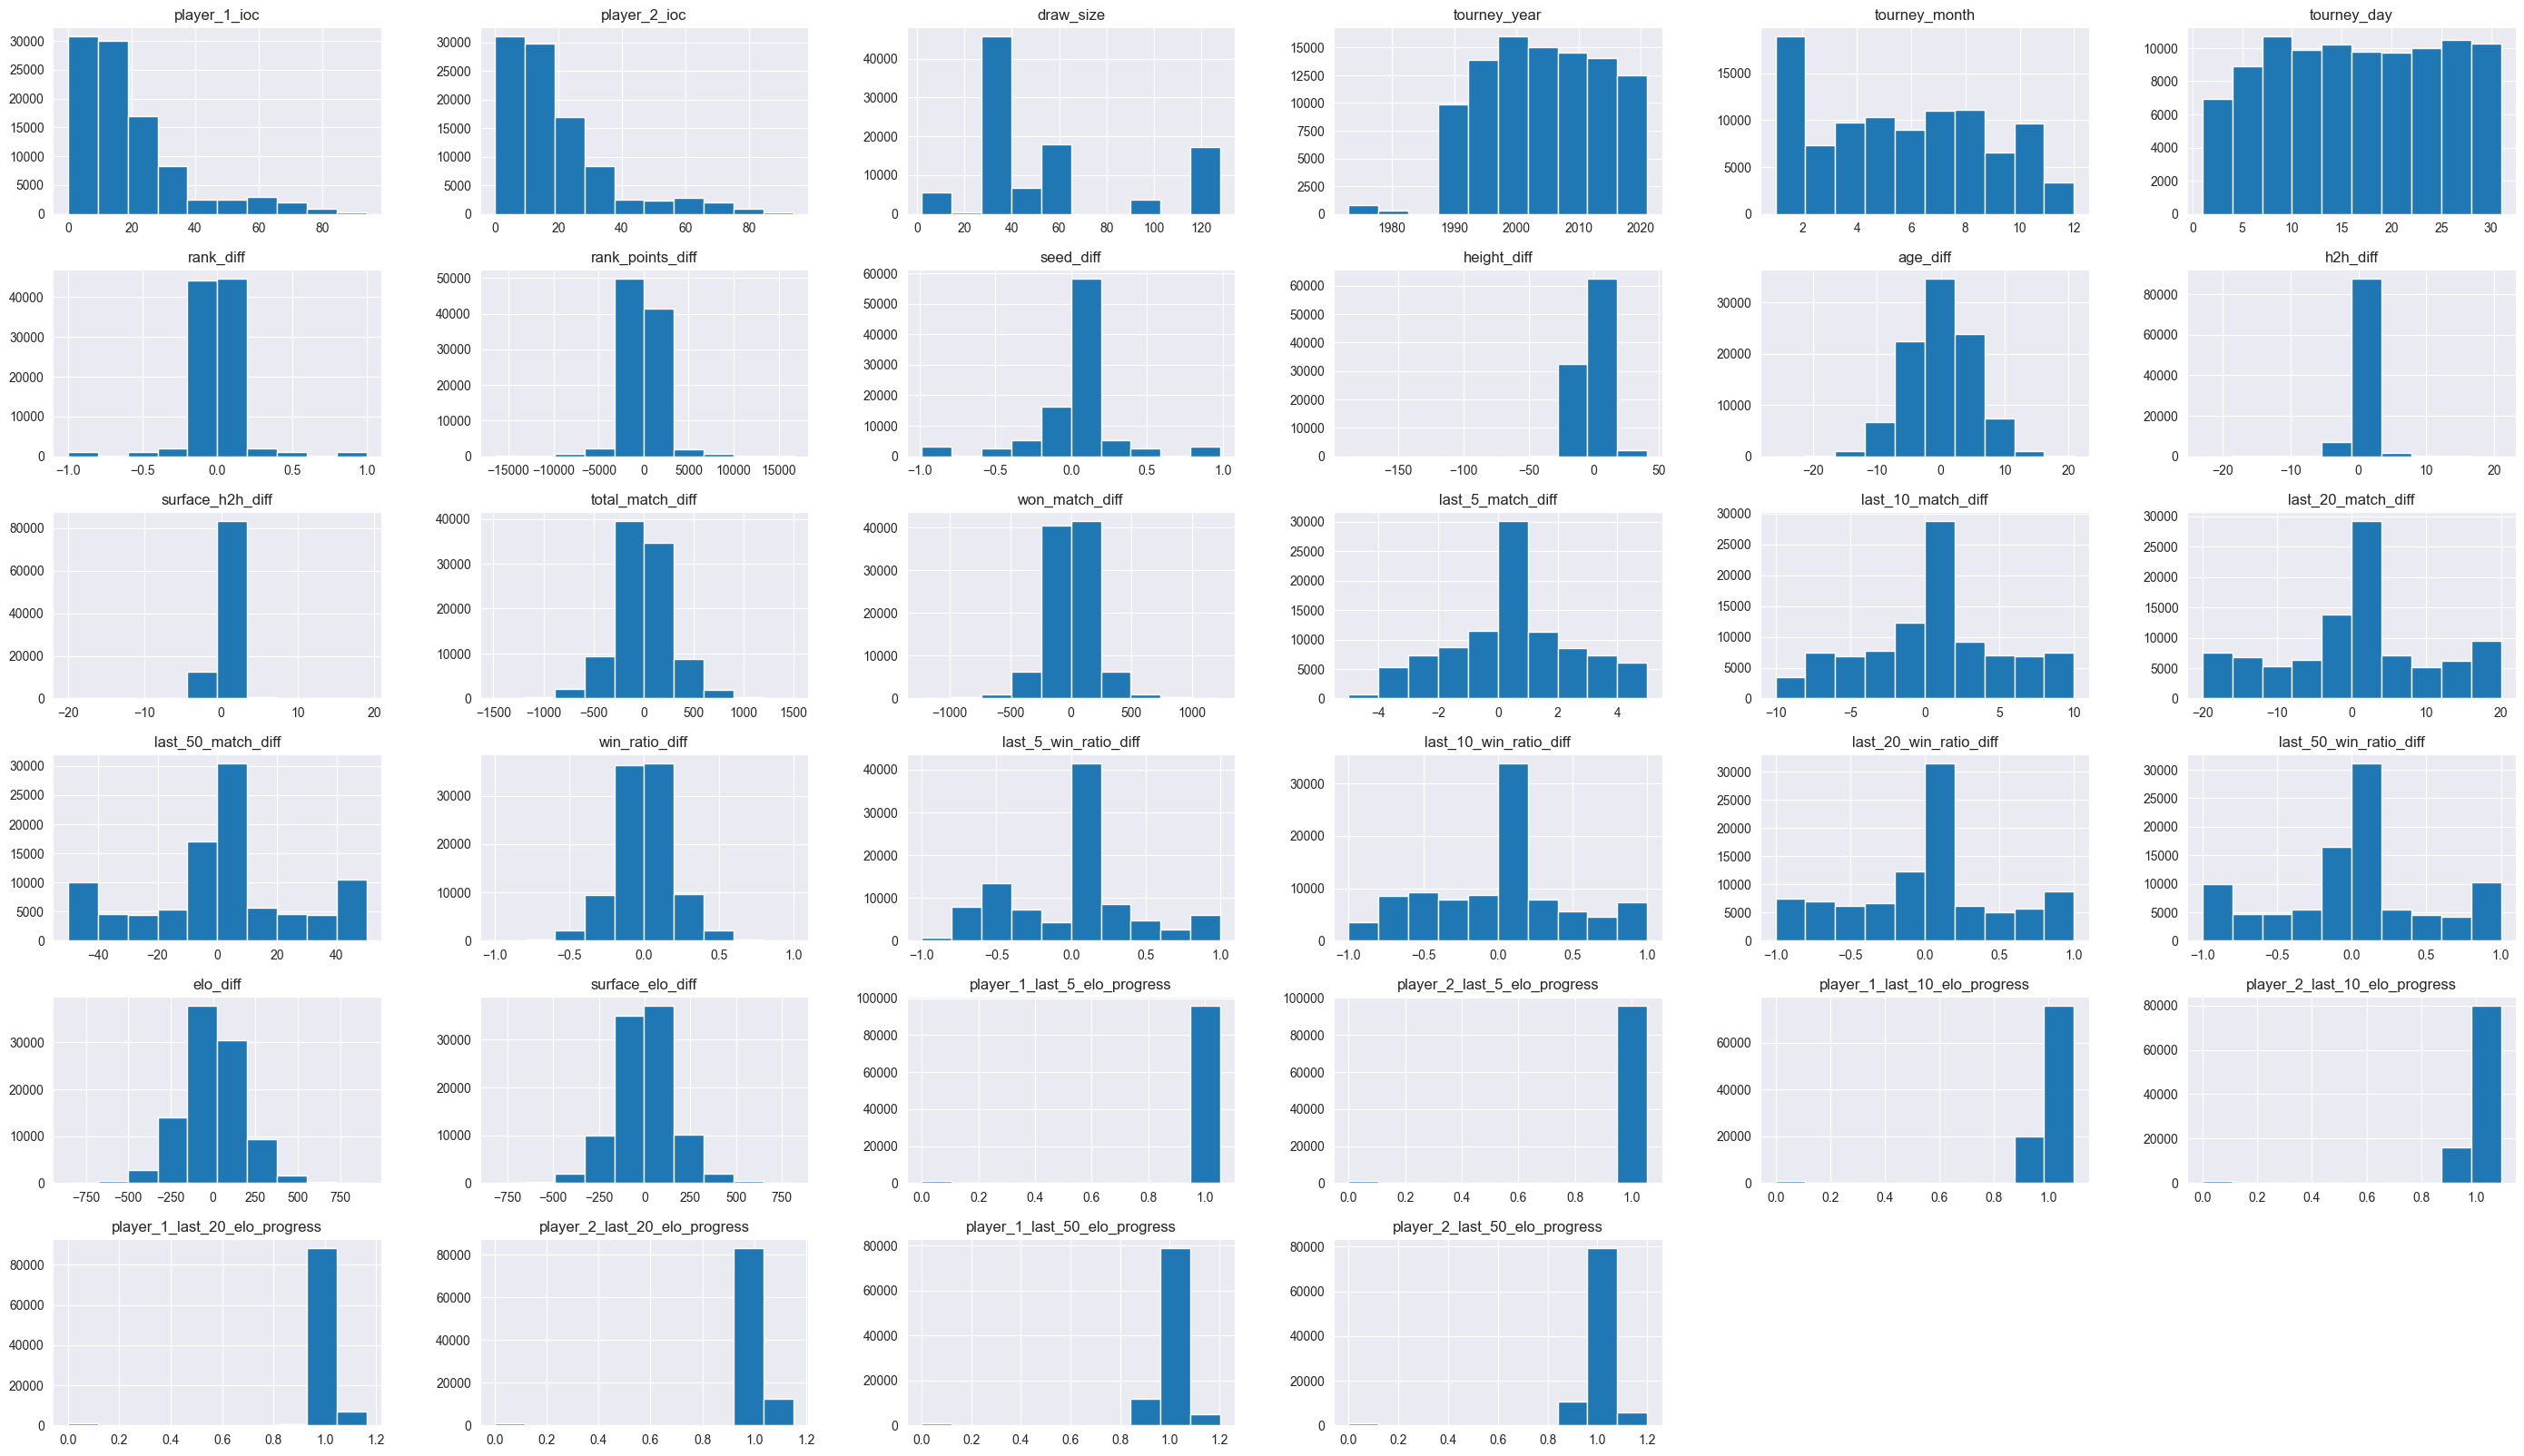

In [8]:
train_data = x_train.join(y_train)
train_data.hist(figsize=(35, 20))

<Axes: >

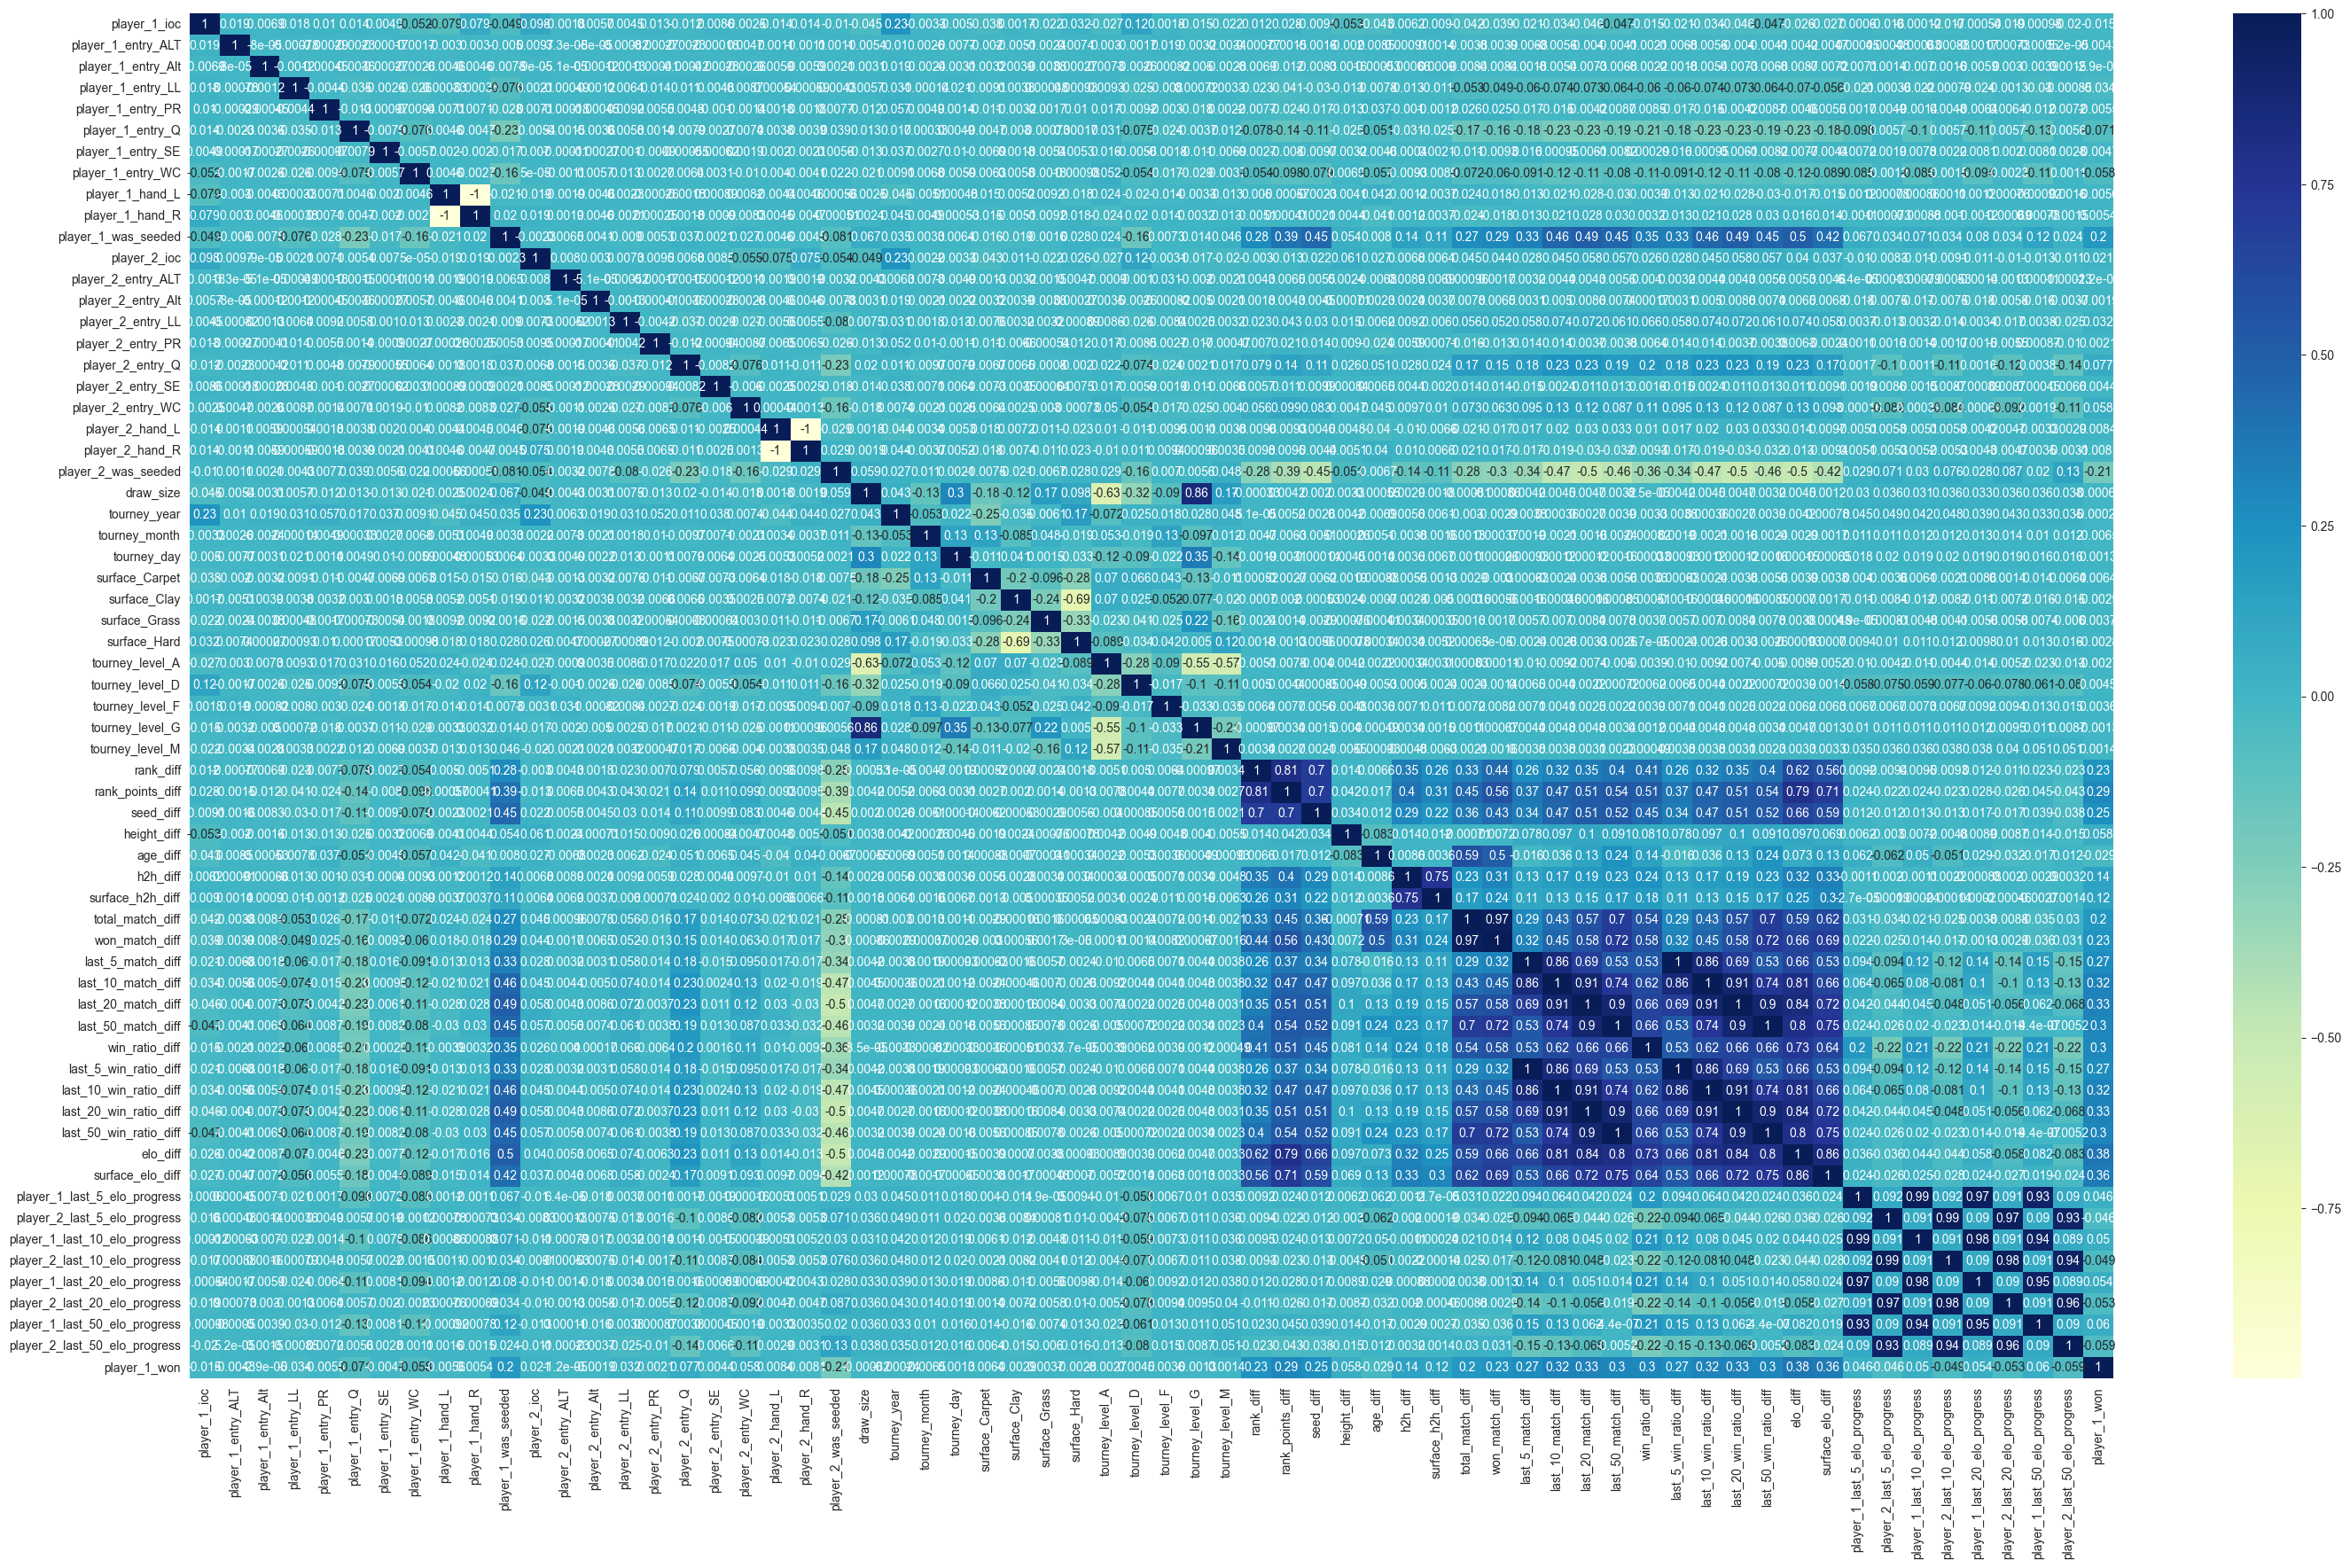

In [9]:
plt.figure(figsize=(35, 20))
sns.heatmap(train_data.corr(), annot = True, cmap = "YlGnBu")

In [10]:
from xgboost import XGBClassifier

model = XGBClassifier(random_state=42, max_depth=6)
model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [11]:
accuracy = model.score(x_test, y_test)
print(f"XGBoost Accuracy -> {accuracy * 100}%")

XGBoost Accuracy -> 64.69975702880944%


In [18]:
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

tscv = TimeSeriesSplit(n_splits=5, gap=5)

val_size   = int(0.1 * len(x_train))
x_tr_tune  = x_train.iloc[:-val_size]
y_tr_tune  = y_train.iloc[:-val_size]
x_val      = x_train.iloc[-val_size:]
y_val      = y_train.iloc[-val_size:]


xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    tree_method='hist',
    n_jobs=-1,
    early_stopping_rounds=100,
)

param_dist = {
    'n_estimators': randint(300, 2000),
    'learning_rate': uniform(0.01, 0.25),
    'max_depth': randint(3, 12),
    'min_child_weight': uniform(1, 9),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 5),
    'lambda': uniform(0, 5),
    'alpha': uniform(0, 5),
}

search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=10,
    scoring='roc_auc',
    cv=tscv,
    verbose=1,
    n_jobs=-1,
    random_state=42,
    refit=True
)

search.fit(x_tr_tune, y_tr_tune,
           eval_set=[(x_val, y_val)],
           verbose=False)

best = search.best_estimator_
best.fit(
    x_train, y_train,
    eval_set=[(x_test, y_test)],
    verbose=False
)

print(f"Best XGBoost AUC: {search.best_score_ * 100:.2f}%")
print("Best parameters:", search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best XGBoost AUC: 73.76%
Best parameters: {'alpha': np.float64(3.4211651325607844), 'colsample_bytree': np.float64(0.7200762468698007), 'gamma': np.float64(0.6101911742238941), 'lambda': np.float64(2.475884550556351), 'learning_rate': np.float64(0.0185971302788046), 'max_depth': 3, 'min_child_weight': np.float64(3.3290198344001523), 'n_estimators': 1711, 'subsample': np.float64(0.6558555380447055)}
